In [1]:
import gym, ray

from time import sleep
from pong import keep_ids

In [2]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [3]:
use_gpu = True

In [4]:
ray.init(num_gpus=int(use_gpu))

2019-02-20 14:13:56,628	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-20_14-13-56_6538/logs.
2019-02-20 14:13:56,735	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:56700 to respond...
2019-02-20 14:13:56,865	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:30778 to respond...
2019-02-20 14:13:56,872	INFO services.py:798 -- Starting Redis shard with 10.0 GB max memory.
2019-02-20 14:13:56,911	INFO services.py:1360 -- Starting the Plasma object store with 3.3281097720000004 GB memory using /dev/shm.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=4a564c95f1d599627983bc87bfd5f80016b014cefa639178



{'node_ip_address': None,
 'redis_address': '192.168.1.21:56700',
 'object_store_address': '/tmp/ray/session_2019-02-20_14-13-56_6538/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=4a564c95f1d599627983bc87bfd5f80016b014cefa639178',
 'raylet_socket_name': '/tmp/ray/session_2019-02-20_14-13-56_6538/sockets/raylet'}

In [5]:
device = torch.device('cuda' if use_gpu else 'cpu')

In [6]:
env = gym.make('Pong-ramDeterministic-v4')

In [7]:
n = env.observation_space.shape[0]
a = 3 #env.action_space.n

In [8]:
rom_action = lambda a: a if a == 0 else a + 2

Hyperparameters

In [9]:
n_steps = 10 ** 6
n_steps_test = 100
lr_actor = 1e-3
lr_critic = 1e-3
gamma = 0.99
tau = 20
n_workers = 16
chi = 1e-2

In [10]:
normalize = lambda x: (x / 127.5 - 1).astype(np.float32)

In [11]:
entropy = lambda x: (-(F.log_softmax(x, dim=-1) * F.softmax(x, dim=-1)).sum(-1)).mean()

In [12]:
def param_cast(params, device):
    for k, v in params.items():
        if isinstance(v, torch.Tensor):
            params[k] = v.to(device)
            
    return params

## Create Model

In [13]:
class Actor(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, a))
        self.device = torch.device('cpu')
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = next(self.children()).weight.data.device
        return self
    
    @torch.no_grad()
    def act(self, observation, probabilistic=True):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=self.device)
            
        if not probabilistic: 
            return self(observation).max(dim=-1)[1].long()
        else:
            return torch.multinomial(F.softmax(self(observation), dim=-1), 1).long()
        
actor = Actor().to(device)

In [14]:
class Critic(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, 1))
        
critic = Critic().to(device)

In [15]:
optimizer_actor = optim.RMSprop(actor.parameters(), lr_actor)
optimizer_critic = optim.RMSprop(critic.parameters(), lr_critic)

In [16]:
@ray.remote
class Worker:
    def __init__(self):
        self.env = gym.make('Pong-ramDeterministic-v4')
        self.actor = Actor()
        self.done = True
        
    def run(self, parameters):
        self.actor.load_state_dict(parameters)
        
        states, actions, rewards = [], [], []
        
        if not self.done: states.append(self.state)
        while len(actions) < tau:
            if self.done:
                self.state = normalize(env.reset())
                states.clear(); actions.clear(); rewards.clear()
                states.append(self.state)
                
            action = self.actor.act(self.state).item()
            self.state, reward, self.done, _ = env.step(rom_action(action))
            self.state = normalize(self.state)
            states.append(self.state); actions.append(action); rewards.append(np.float32(reward))
            
        done = np.array(self.done, dtype=np.float32)
        return np.stack(states), np.stack(actions), np.stack(rewards), done

## Train

In [17]:
total_rewards = []
actor_losses = []
critic_losses = []
entropy_losses = []

In [18]:
def get_advantages(states, actions, rewards, dones):
    advantages = torch.zeros_like(rewards)
    
    optimizer_critic.zero_grad()
    
    # Remember to detach
    R = critic(states[:, -1]).squeeze(1).detach() * (1 - dones) # Returns
    
    for i in range(tau)[::-1]:
        R = rewards[:, i] + gamma * R
        advantages[:, i] = R - critic(states[:, i]).squeeze(1)
        
    return advantages

In [19]:
def train_actor_step(states, actions, advantages):
    optimizer_actor.zero_grad()
    action_scores = actor(states[:, :-1])
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_actor = torch.mean(torch.stack([adv * F.cross_entropy(s, a, reduction='none')
                                         for s, a, adv in zip(action_scores.transpose(0, 1),
                                                              actions.t(),
                                                              advantages.detach().t())]))
    loss_entropy = entropy(action_scores)
    loss = loss_actor - chi * loss_entropy
    loss.backward()
    optimizer_actor.step()
    
    return loss_actor.item(), loss_entropy.item()

In [20]:
def train_critic_step(advantages):
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_critic = F.mse_loss(advantages, torch.zeros_like(advantages))
    loss_critic.backward()
    optimizer_critic.step()
    
    return loss_critic.item()

In [21]:
def test_one_episode(n_steps, probabilistic=True):
    state = normalize(env.reset())
    done = False
    total_rewards = 0
    
    for step in range(n_steps):
        action = actor.act(state, probabilistic).item()
        next_state, reward, done, _ = env.step(rom_action(action))
        
        total_rewards += reward
        state = normalize(next_state)
        if done: break
            
    return total_rewards

In [22]:
 """
actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))
critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))
optimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))
optimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))
 """

"\nactor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))\ncritic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))\noptimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))\noptimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))\n"

In [23]:
workers = [Worker.remote() for _ in range(n_workers)]

In [24]:
pbar = tqdm(range(n_steps // (tau * n_workers)))
for step in pbar:
    params = ray.put(param_cast(actor.state_dict(), 'cpu'))
    results = ray.get([worker.run.remote(params) for worker in workers])

    states, actions, rewards, dones = [torch.tensor(np.stack(x), device=device)
                                       for x in zip(*results)]

    advantages = get_advantages(states, actions, rewards, dones)

    loss_actor, loss_entropy = train_actor_step(states, actions, advantages)
    loss_critic = train_critic_step(advantages)
    if step == 3: break

    if not step % 100:
        actor_losses.append(loss_actor)
        entropy_losses.append(loss_entropy)
        critic_losses.append(loss_critic)
        total_rewards.append(test_one_episode(n_steps_test))
        pbar.set_description(f'{total_rewards[-1]:.2f}')

2019-02-20 14:01:05,520	ERROR worker.py:1632 -- WARNING: 24 workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


In [25]:
torch.save(actor.state_dict(), DIR_NB / 'checkpoints' / 'actor.pt')
torch.save(critic.state_dict(), DIR_NB / 'checkpoints' / 'critic.pt')
torch.save(optimizer_actor.state_dict(), DIR_NB / 'checkpoints' / 'actor-opt.pt')
torch.save(optimizer_critic.state_dict(), DIR_NB / 'checkpoints' / 'critic-opt.pt')

In [26]:
groupmean = lambda x, n=1: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

In [27]:
jtplot_style()

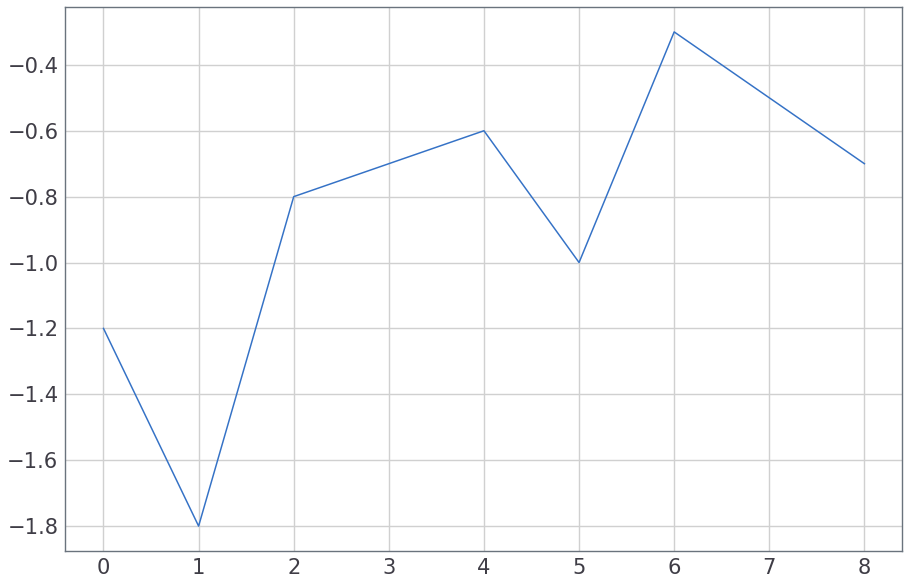

In [28]:
plot(groupmean(total_rewards, 10))

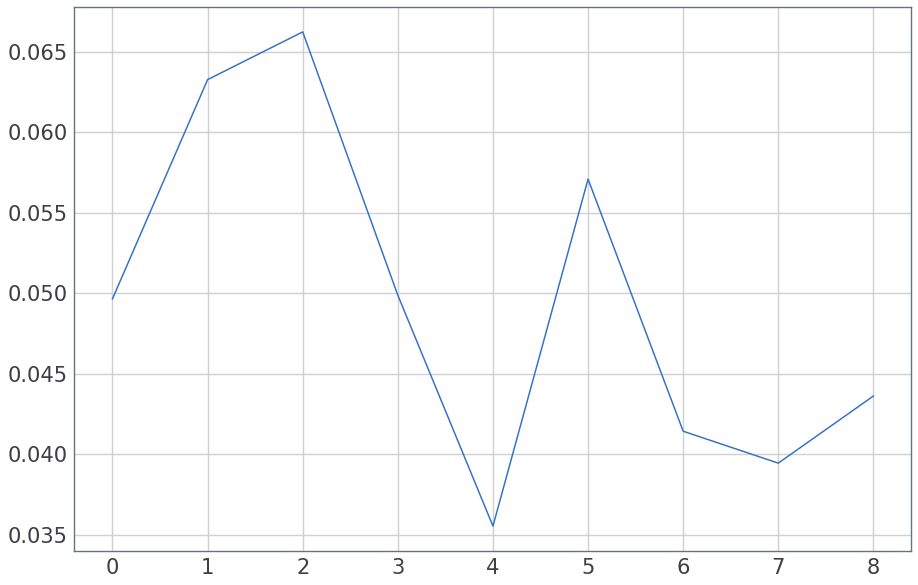

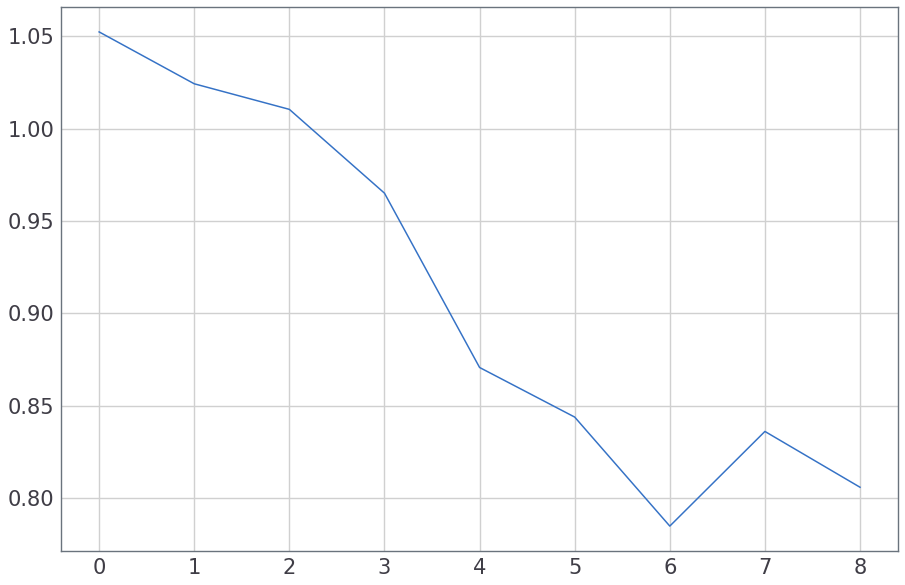

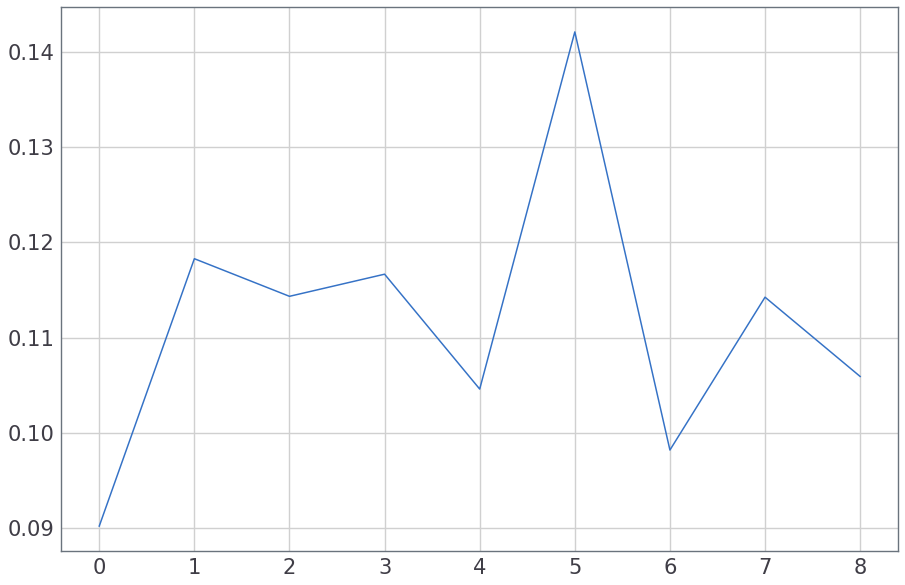

In [29]:
plot(groupmean(np.abs(actor_losses), 10)); plt.show()
plot(groupmean(np.abs(entropy_losses), 10)); plt.show()
plot(groupmean(critic_losses, 10)); plt.show()

In [30]:
test_one_episode(10000, probabilistic=False)

-17.0

In [31]:
test_one_episode(10000, probabilistic=True)

-12.0

In [38]:
for episode in range(1):
    state = normalize(env.reset())
    done = False
    r = 0

    for step in range(500):
        env.render()
        action = actor.act(state, probabilistic=True).item()
        with torch.no_grad():
            a = actor(torch.tensor(state, device=device)).cpu().numpy()
            print('Actor', a)
            print('Critic', critic(torch.tensor(state, device=device)).squeeze().item())
        state, reward, done, _ = env.step(rom_action(action))
        state = normalize(state)
        r += reward
        
        sleep(0.01)
        if done: break

    env.close()
    print(r)

Actor [ 0.30151826 -1.4259169   1.1447303 ]
Critic -0.4819510579109192
Actor [ 0.27058554 -1.1632165   0.53229874]
Critic -0.4519497752189636
Actor [ 0.24253567 -0.36258167 -0.38764352]
Critic -0.4531419277191162
Actor [ 0.29640874 -0.4868586  -0.04713237]
Critic -0.4538695216178894
Actor [ 0.29290128 -0.3768801  -0.173173  ]
Critic -0.45763200521469116
Actor [ 0.2930295  -0.3848759  -0.16476701]
Critic -0.4617777466773987
Actor [ 0.21655302  0.61875534 -1.4702375 ]
Critic -0.46603626012802124
Actor [ 0.28332657  0.03156061 -0.63203144]
Critic -0.4681418538093567
Actor [ 0.21393518  0.7314756  -1.5900052 ]
Critic -0.4735386371612549
Actor [ 0.2834041   0.01543929 -0.6155591 ]
Critic -0.47607946395874023
Actor [ 0.3021081  -0.66122806  0.14919971]
Critic -0.48239028453826904
Actor [ 0.32975894 -1.59229     1.2205575 ]
Critic -0.48841023445129395
Actor [ 0.27221018 -1.1478462   0.5065068 ]
Critic -0.49415820837020874
Actor [ 0.24402498 -0.41440684 -0.33493376]
Critic -0.4962329864501953


Actor [ 0.16493048  0.01233365 -0.00645923]
Critic -0.6221080422401428
Actor [ 0.15510298 -0.08750309  0.15685514]
Critic -0.6146981716156006
Actor [ 0.12146975 -0.8039809   1.3161983 ]
Critic -0.6088549494743347
Actor [ 0.09040415 -1.4567448   2.1069858 ]
Critic -0.5970131754875183
Actor [ 0.0678589  -0.42666912  0.2717364 ]
Critic -0.5984208583831787
Actor [ 0.09328572 -0.6292244   0.8961925 ]
Critic -0.607459545135498
Actor [ 0.04115333  0.57793343 -0.42998123]
Critic -0.6108659505844116
Actor [0.04705147 0.05839922 0.58080727]
Critic -0.6156604290008545
Actor [-0.00926219  1.3603595  -1.4928739 ]
Critic -0.6230785846710205
Actor [ 0.04673252  0.8149817  -0.4726835 ]
Critic -0.6289418935775757
Actor [0.00167167 0.26630276 0.46651506]
Critic -0.6228466629981995
Actor [-0.02714586 -0.13272437  0.9253936 ]
Critic -0.6210074424743652
Actor [ 0.0040491  -0.10117294  0.6103766 ]
Critic -0.6263661980628967
Actor [-0.04885799  0.8489705  -0.44654542]
Critic -0.6248564124107361
Actor [-0.094

Actor [0.06568199 0.19991194 0.6604527 ]
Critic -0.5021061301231384
Actor [ 0.03746608 -0.5893618   1.548921  ]
Critic -0.5035824179649353
Actor [-0.02036889  0.2983353   0.5476141 ]
Critic -0.5015305280685425
Actor [-0.04521126  1.4950558  -0.7363089 ]
Critic -0.518261194229126
Actor [-0.01443094  1.4101306  -0.53082263]
Critic -0.542096734046936
Actor [-0.06586727  0.8855339   0.39396107]
Critic -0.5433138012886047
Actor [-0.09467831  0.442343    0.89317274]
Critic -0.5492340326309204
Actor [-0.04794499  0.5198463   0.5659989 ]
Critic -0.5637109279632568
Actor [-0.11072235  1.7532622  -1.1646601 ]
Critic -0.5660344958305359
Actor [-0.1527436   0.82771343  0.5654648 ]
Critic -0.5819063782691956
Actor [-0.16574313  1.8228878  -0.92079115]
Critic -0.5828822255134583
Actor [-0.11707549  1.7659097  -0.61211383]
Critic -0.4197961091995239
Actor [ 0.15637016 -1.375727    2.3345354 ]
Critic -0.3028472661972046
Actor [ 0.17697018 -0.50987923  0.9750547 ]
Critic -0.30400317907333374
Actor [ 0.

Actor [ 0.19219677  0.6573626  -0.74473214]
Critic -0.42740291357040405
Actor [ 0.1721012   0.32357365 -0.6190036 ]
Critic -0.4135531783103943
Actor [ 0.16904195  0.08107801 -0.32999915]
Critic -0.39775991439819336
Actor [0.16869524 0.02979819 0.04156063]
Critic -0.37254583835601807
Actor [ 0.1514708  -0.22700168  0.34889507]
Critic -0.35338228940963745
Actor [ 0.01794068  1.1876103  -2.0214887 ]
Critic -0.3859173655509949
Actor [ 0.10012638  0.5216343  -0.72364044]
Critic -0.33324235677719116
Actor [ 0.08746873 -0.13896742  0.34819403]
Critic -0.2904805541038513
Actor [ 0.06010437 -0.40700567  0.68466556]
Critic -0.2643950581550598
Actor [ 0.05571236  0.10791518 -0.17689194]
Critic -0.2518607974052429
Actor [ 0.03345328  0.37672615 -0.4466008 ]
Critic -0.2346913069486618
Actor [ 0.00587852  0.45994842 -0.16924675]
Critic -0.20516787469387054
Actor [-0.01145533  0.73863524 -0.44274884]
Critic -0.18825523555278778
Actor [ 0.08536527  0.20067184 -0.26671165]
Critic -0.01422649621963501
A

Actor [ 0.27641547 -0.8928525   0.6505356 ]
Critic -0.47879844903945923
Actor [ 0.27041626 -1.0836278   0.6092921 ]
Critic -0.4828997850418091
Actor [ 0.17216676 -0.18604486 -0.6394079 ]
Critic -0.4942973256111145
Actor [ 0.1059939   0.89694715 -2.067223  ]
Critic -0.5073016881942749
Actor [ 0.25304657 -0.11202206 -0.30266142]
Critic -0.472723126411438
Actor [ 0.21781127 -0.14836992 -0.5484946 ]
Critic -0.48306888341903687
Actor [ 0.25895602 -0.7234468   0.42953742]
Critic -0.48011714220046997
Actor [ 0.26670069 -1.3296806   0.87229913]
Critic -0.48429030179977417
Actor [ 0.3132082 -2.7784452  2.5841005]
Critic -0.6944505572319031
-4.0
